# CNN-Based Copy Number Variation (CNV) Analysis
# Genetic Testing Pipeline

This notebook demonstrates a complete pipeline for detecting copy number variations using convolutional neural networks.

**Components:**
1. Simulated genomic coverage data generation
2. CNN architecture for CNV detection
3. Model training and evaluation
4. Comprehensive visualizations

**Compatible with Apple Silicon Macs**

In [4]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# Create output directory
OUTPUT_DIR = Path('./outputs')
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Output directory: {OUTPUT_DIR.absolute()}")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA GPU")
else:
    device = torch.device('cpu')
    print(f"Using CPU")

print(f"PyTorch version: {torch.__version__}")

Output directory: /Users/shanebrubaker/work/courses/outputs
Using Apple Silicon GPU (MPS)
PyTorch version: 2.1.0


## 1. Simulated Genomic Coverage Data Generation

We'll simulate read depth coverage data across genomic windows with three scenarios:
- **Normal (Class 0)**: Diploid coverage (2 copies)
- **Deletion (Class 1)**: Reduced coverage (1 copy or homozygous deletion)
- **Duplication (Class 2)**: Increased coverage (3+ copies)

In [5]:
def generate_coverage_data(n_samples=1000, window_size=200, baseline_coverage=50):
    """
    Generate simulated genomic coverage data for CNV detection.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples per class
    window_size : int
        Number of genomic windows (features)
    baseline_coverage : float
        Expected coverage for diploid regions
    
    Returns:
    --------
    X : numpy array of shape (n_samples*3, window_size, 1)
        Coverage data
    y : numpy array of shape (n_samples*3,)
        Labels (0=normal, 1=deletion, 2=duplication)
    """
    
    X_normal = []
    X_deletion = []
    X_duplication = []
    
    for _ in range(n_samples):
        # Normal coverage (diploid, 2 copies)
        normal = np.random.poisson(baseline_coverage, window_size)
        # Add some biological noise (GC bias, mappability)
        gc_bias = np.sin(np.linspace(0, 2*np.pi, window_size)) * 5
        normal = normal + gc_bias + np.random.normal(0, 3, window_size)
        X_normal.append(normal)
        
        # Deletion (hemizygous ~0.5x or homozygous deletion ~0x)
        deletion_factor = np.random.uniform(0.1, 0.6)  # 10-60% of normal coverage
        # Create a deletion region in the middle
        deletion = np.random.poisson(baseline_coverage, window_size)
        deletion = deletion + gc_bias + np.random.normal(0, 3, window_size)
        deletion_start = window_size // 4
        deletion_end = 3 * window_size // 4
        deletion[deletion_start:deletion_end] *= deletion_factor
        X_deletion.append(deletion)
        
        # Duplication (3+ copies)
        duplication_factor = np.random.uniform(1.4, 2.5)  # 140-250% of normal coverage
        # Create a duplication region in the middle
        duplication = np.random.poisson(baseline_coverage, window_size)
        duplication = duplication + gc_bias + np.random.normal(0, 3, window_size)
        dup_start = window_size // 4
        dup_end = 3 * window_size // 4
        duplication[dup_start:dup_end] *= duplication_factor
        X_duplication.append(duplication)
    
    # Combine all data
    X_normal = np.array(X_normal)
    X_deletion = np.array(X_deletion)
    X_duplication = np.array(X_duplication)
    
    X = np.vstack([X_normal, X_deletion, X_duplication])
    y = np.hstack([np.zeros(n_samples), np.ones(n_samples), np.ones(n_samples)*2])
    
    # Normalize coverage data
    X = X.reshape(-1, window_size, 1).astype(np.float32)
    
    # Shuffle the data
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices].astype(np.int64)
    
    return X, y

# Generate training and test data
print("Generating training data...")
X_train, y_train = generate_coverage_data(n_samples=800, window_size=200)

print("Generating test data...")
X_test, y_test = generate_coverage_data(n_samples=200, window_size=200)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nTraining set class distribution:")
print(f"  Normal (0): {counts[0]} samples")
print(f"  Deletion (1): {counts[1]} samples")
print(f"  Duplication (2): {counts[2]} samples")

Generating training data...
Generating test data...

Training set shape: (2400, 200, 1)
Training labels shape: (2400,)
Test set shape: (600, 200, 1)
Test labels shape: (600,)

Training set class distribution:
  Normal (0): 800 samples
  Deletion (1): 800 samples
  Duplication (2): 800 samples


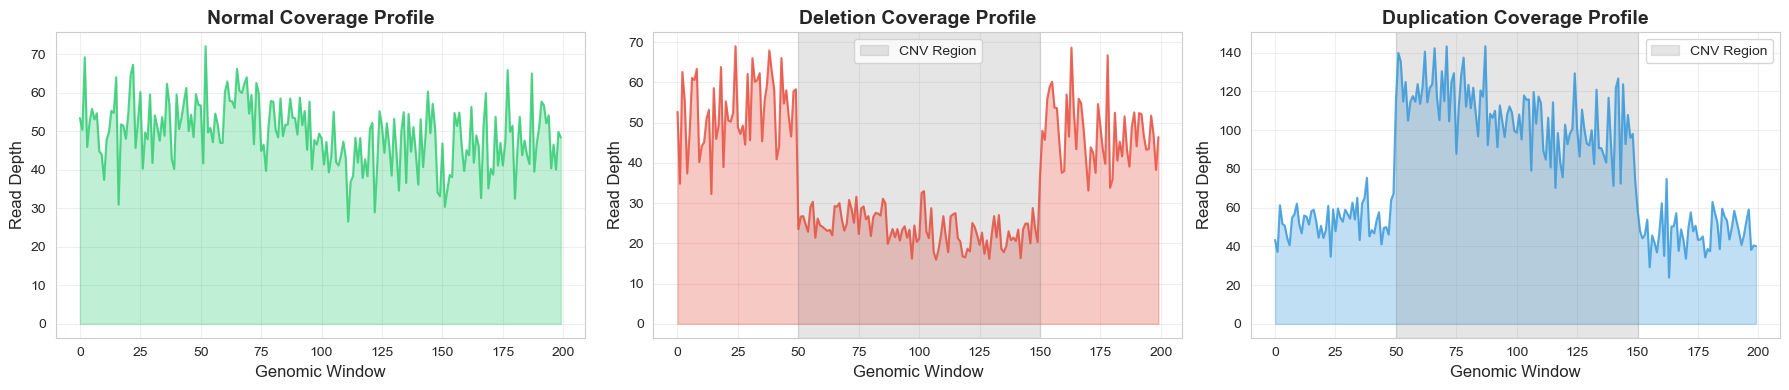

✓ Coverage profiles saved to: outputs/coverage_profiles.png


In [6]:
# Visualize example coverage profiles
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

class_names = ['Normal', 'Deletion', 'Duplication']
colors = ['#2ecc71', '#e74c3c', '#3498db']

for class_idx, (ax, name, color) in enumerate(zip(axes, class_names, colors)):
    # Find an example of this class
    example_idx = np.where(y_train == class_idx)[0][0]
    coverage = X_train[example_idx].flatten()
    
    ax.plot(coverage, color=color, linewidth=1.5, alpha=0.8)
    ax.fill_between(range(len(coverage)), coverage, alpha=0.3, color=color)
    ax.set_title(f'{name} Coverage Profile', fontsize=14, fontweight='bold')
    ax.set_xlabel('Genomic Window', fontsize=12)
    ax.set_ylabel('Read Depth', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add shaded region for CNV location
    if class_idx > 0:  # Deletion or Duplication
        ax.axvspan(50, 150, alpha=0.2, color='gray', label='CNV Region')
        ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'coverage_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Coverage profiles saved to: {OUTPUT_DIR / 'coverage_profiles.png'}")

## 2. CNN Architecture for CNV Detection

Our CNN architecture:
- **Conv1D layers**: Extract local patterns in coverage data
- **Batch Normalization**: Stabilize training
- **MaxPooling**: Reduce dimensionality
- **Dropout**: Prevent overfitting
- **Fully Connected layers**: Classification

In [7]:
class CNV_CNN(nn.Module):
    """
    Convolutional Neural Network for Copy Number Variation detection.
    
    Architecture:
    - 3 Convolutional blocks (Conv1D + BatchNorm + ReLU + MaxPool)
    - 2 Fully connected layers
    - Dropout for regularization
    """
    
    def __init__(self, input_size=200, num_classes=3):
        super(CNV_CNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Convolutional Block 3
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate size after convolutions and pooling
        # input_size=200 -> after 3 maxpool(2): 200/2/2/2 = 25
        self.fc_input_size = 128 * 25
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x shape: (batch, 200, 1) -> need (batch, 1, 200)
        x = x.permute(0, 2, 1)
        
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

# Initialize model
model = CNV_CNN(input_size=200, num_classes=3).to(device)

print("CNN Model Architecture:")
print("="*60)
print(model)
print("="*60)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

CNN Model Architecture:
CNV_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear

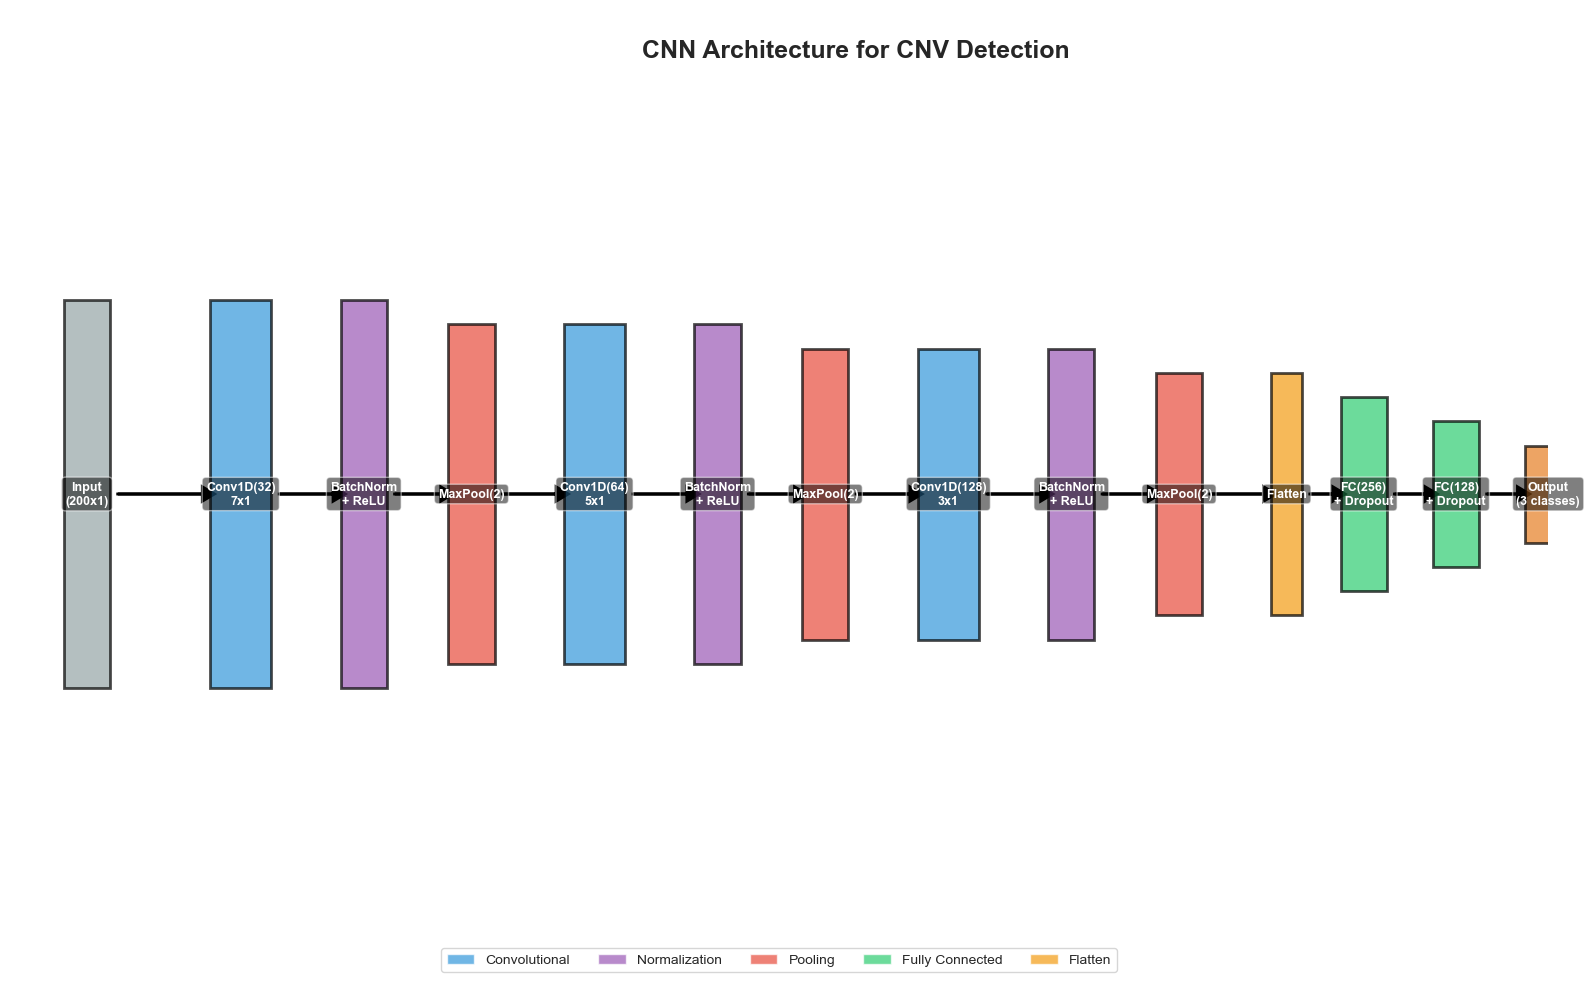

✓ CNN architecture saved to: outputs/cnn_architecture.png


In [8]:
# Visualize CNN Architecture
def visualize_cnn_architecture():
    """
    Create a visual representation of the CNN architecture.
    """
    fig, ax = plt.subplots(figsize=(16, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Define layer positions and properties
    layers = [
        {'name': 'Input\n(200x1)', 'x': 0.5, 'y': 5, 'width': 0.3, 'height': 4, 'color': '#95a5a6'},
        {'name': 'Conv1D(32)\n7x1', 'x': 1.5, 'y': 5, 'width': 0.4, 'height': 4, 'color': '#3498db'},
        {'name': 'BatchNorm\n+ ReLU', 'x': 2.3, 'y': 5, 'width': 0.3, 'height': 4, 'color': '#9b59b6'},
        {'name': 'MaxPool(2)', 'x': 3.0, 'y': 5, 'width': 0.3, 'height': 3.5, 'color': '#e74c3c'},
        
        {'name': 'Conv1D(64)\n5x1', 'x': 3.8, 'y': 5, 'width': 0.4, 'height': 3.5, 'color': '#3498db'},
        {'name': 'BatchNorm\n+ ReLU', 'x': 4.6, 'y': 5, 'width': 0.3, 'height': 3.5, 'color': '#9b59b6'},
        {'name': 'MaxPool(2)', 'x': 5.3, 'y': 5, 'width': 0.3, 'height': 3, 'color': '#e74c3c'},
        
        {'name': 'Conv1D(128)\n3x1', 'x': 6.1, 'y': 5, 'width': 0.4, 'height': 3, 'color': '#3498db'},
        {'name': 'BatchNorm\n+ ReLU', 'x': 6.9, 'y': 5, 'width': 0.3, 'height': 3, 'color': '#9b59b6'},
        {'name': 'MaxPool(2)', 'x': 7.6, 'y': 5, 'width': 0.3, 'height': 2.5, 'color': '#e74c3c'},
        
        {'name': 'Flatten', 'x': 8.3, 'y': 5, 'width': 0.2, 'height': 2.5, 'color': '#f39c12'},
        {'name': 'FC(256)\n+ Dropout', 'x': 8.8, 'y': 5, 'width': 0.3, 'height': 2, 'color': '#2ecc71'},
        {'name': 'FC(128)\n+ Dropout', 'x': 9.4, 'y': 5, 'width': 0.3, 'height': 1.5, 'color': '#2ecc71'},
        {'name': 'Output\n(3 classes)', 'x': 10.0, 'y': 5, 'width': 0.3, 'height': 1, 'color': '#e67e22'},
    ]
    
    # Draw layers
    for i, layer in enumerate(layers):
        # Draw rectangle
        rect = plt.Rectangle(
            (layer['x'] - layer['width']/2, layer['y'] - layer['height']/2),
            layer['width'], layer['height'],
            facecolor=layer['color'], edgecolor='black', linewidth=2, alpha=0.7
        )
        ax.add_patch(rect)
        
        # Add text
        ax.text(layer['x'], layer['y'], layer['name'],
                ha='center', va='center', fontsize=9, fontweight='bold',
                color='white', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
        
        # Draw arrows between layers
        if i < len(layers) - 1:
            next_layer = layers[i + 1]
            ax.arrow(layer['x'] + layer['width']/2 + 0.05, layer['y'],
                    next_layer['x'] - next_layer['width']/2 - layer['x'] - layer['width']/2 - 0.1, 0,
                    head_width=0.15, head_length=0.08, fc='black', ec='black', linewidth=2)
    
    # Add title and legend
    ax.text(5.5, 9.5, 'CNN Architecture for CNV Detection',
            ha='center', fontsize=18, fontweight='bold')
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, fc='#3498db', alpha=0.7, label='Convolutional'),
        plt.Rectangle((0, 0), 1, 1, fc='#9b59b6', alpha=0.7, label='Normalization'),
        plt.Rectangle((0, 0), 1, 1, fc='#e74c3c', alpha=0.7, label='Pooling'),
        plt.Rectangle((0, 0), 1, 1, fc='#2ecc71', alpha=0.7, label='Fully Connected'),
        plt.Rectangle((0, 0), 1, 1, fc='#f39c12', alpha=0.7, label='Flatten'),
    ]
    ax.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'cnn_architecture.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

visualize_cnn_architecture()
print(f"✓ CNN architecture saved to: {OUTPUT_DIR / 'cnn_architecture.png'}")

## 3. Model Training

In [9]:
# Prepare data loaders
train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print("Training Configuration:")
print(f"  Batch size: 32")
print(f"  Learning rate: 0.001")
print(f"  Optimizer: Adam")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Device: {device}")

Training Configuration:
  Batch size: 32
  Learning rate: 0.001
  Optimizer: Adam
  Loss function: CrossEntropyLoss
  Device: mps


In [10]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Training loop
num_epochs = 50
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("\nStarting training...\n")
print(f"{'Epoch':<6} {'Train Loss':<12} {'Train Acc':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("="*60)

best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), OUTPUT_DIR / 'best_cnv_model.pth')
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"{epoch+1:<6} {train_loss:<12.4f} {train_acc:<12.2f} {val_loss:<12.4f} {val_acc:<12.2f}")

print("="*60)
print(f"\nTraining completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved to: {OUTPUT_DIR / 'best_cnv_model.pth'}")


Starting training...

Epoch  Train Loss   Train Acc    Val Loss     Val Acc     
1      0.0499       98.00        0.0000       100.00      
5      0.0000       100.00       0.0000       100.00      
10     0.0055       99.83        0.0000       100.00      
15     0.0001       100.00       0.0000       100.00      
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
20     0.0003       100.00       0.0000       100.00      
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.
25     0.0000       100.00       0.0000       100.00      
Epoch 00028: reducing learning rate of group 0 to 1.2500e-04.
30     0.0051       99.96        0.0000       100.00      
Epoch 00034: reducing learning rate of group 0 to 6.2500e-05.
35     0.0001       100.00       0.0000       100.00      
Epoch 00040: reducing learning rate of group 0 to 3.1250e-05.
40     0.0000       100.00       0.0000       100.00      
45     0.0000       100.00       0.0000       100.00      
Epoch 00046: reduc

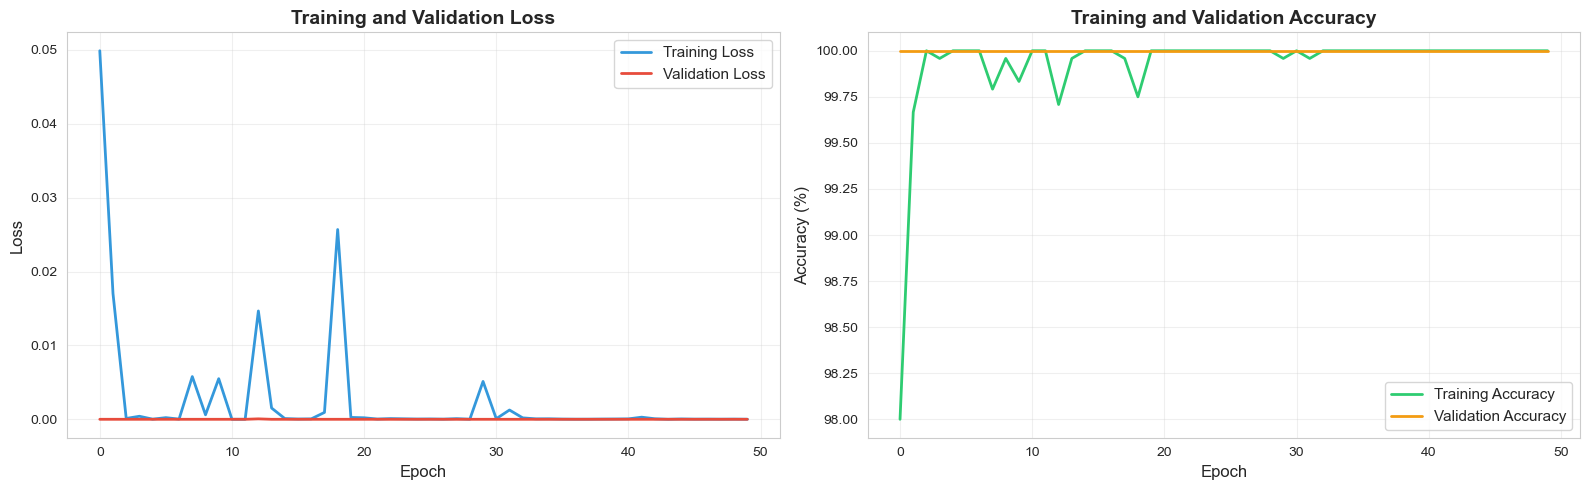

✓ Training history saved to: outputs/training_history.png


In [11]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', linewidth=2, color='#3498db')
ax1.plot(val_losses, label='Validation Loss', linewidth=2, color='#e74c3c')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Training Accuracy', linewidth=2, color='#2ecc71')
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2, color='#f39c12')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training history saved to: {OUTPUT_DIR / 'training_history.png'}")

## 4. Model Evaluation and Results Visualization

In [12]:
# Load best model
model.load_state_dict(torch.load(OUTPUT_DIR / 'best_cnv_model.pth'))
model.eval()

# Get predictions
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Classification report
class_names = ['Normal', 'Deletion', 'Duplication']
print("\nClassification Report:")
print("="*60)
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Classification Report:
              precision    recall  f1-score   support

      Normal     1.0000    1.0000    1.0000       200
    Deletion     1.0000    1.0000    1.0000       200
 Duplication     1.0000    1.0000    1.0000       200

    accuracy                         1.0000       600
   macro avg     1.0000    1.0000    1.0000       600
weighted avg     1.0000    1.0000    1.0000       600



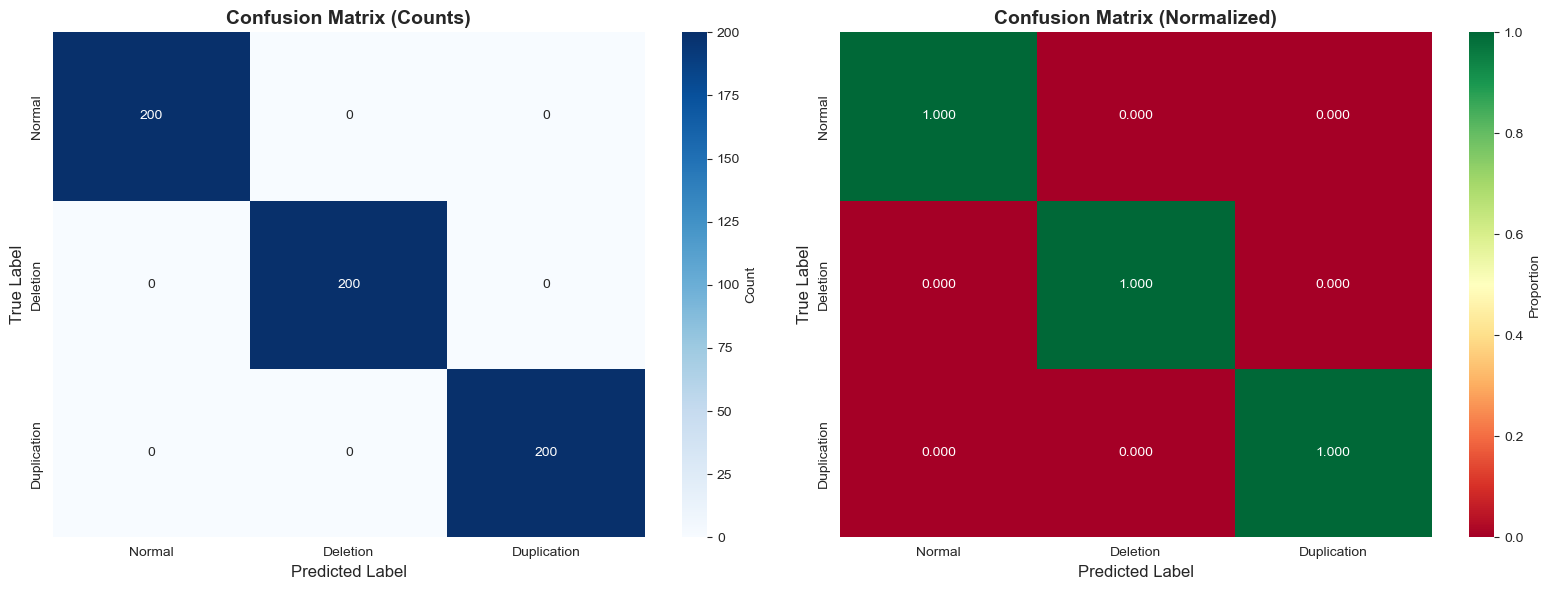

✓ Confusion matrix saved to: outputs/confusion_matrix.png


In [13]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Normalized
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='RdYlGn', xticklabels=class_names,
            yticklabels=class_names, ax=ax2, cbar_kws={'label': 'Proportion'})
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion matrix saved to: {OUTPUT_DIR / 'confusion_matrix.png'}")

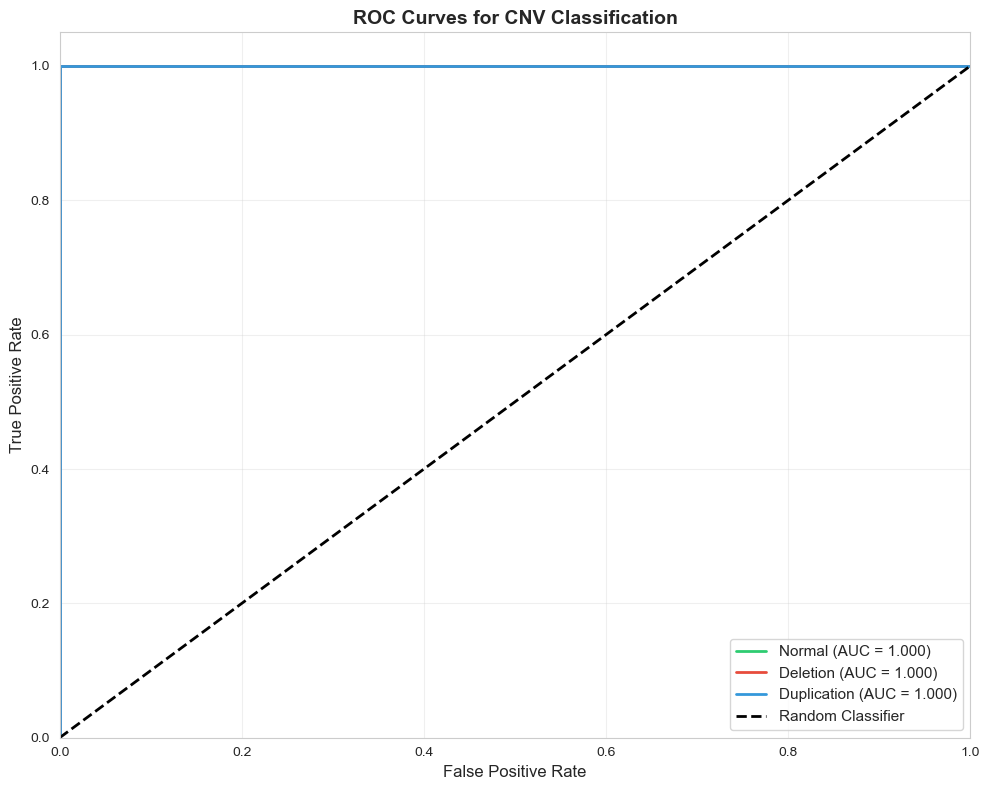

✓ ROC curves saved to: outputs/roc_curves.png


In [14]:
# ROC Curves for multi-class classification
y_test_bin = label_binarize(all_labels, classes=[0, 1, 2])

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#2ecc71', '#e74c3c', '#3498db']
for i, (class_name, color) in enumerate(zip(class_names, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, 
            label=f'{class_name} (AUC = {roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves for CNV Classification', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC curves saved to: {OUTPUT_DIR / 'roc_curves.png'}")

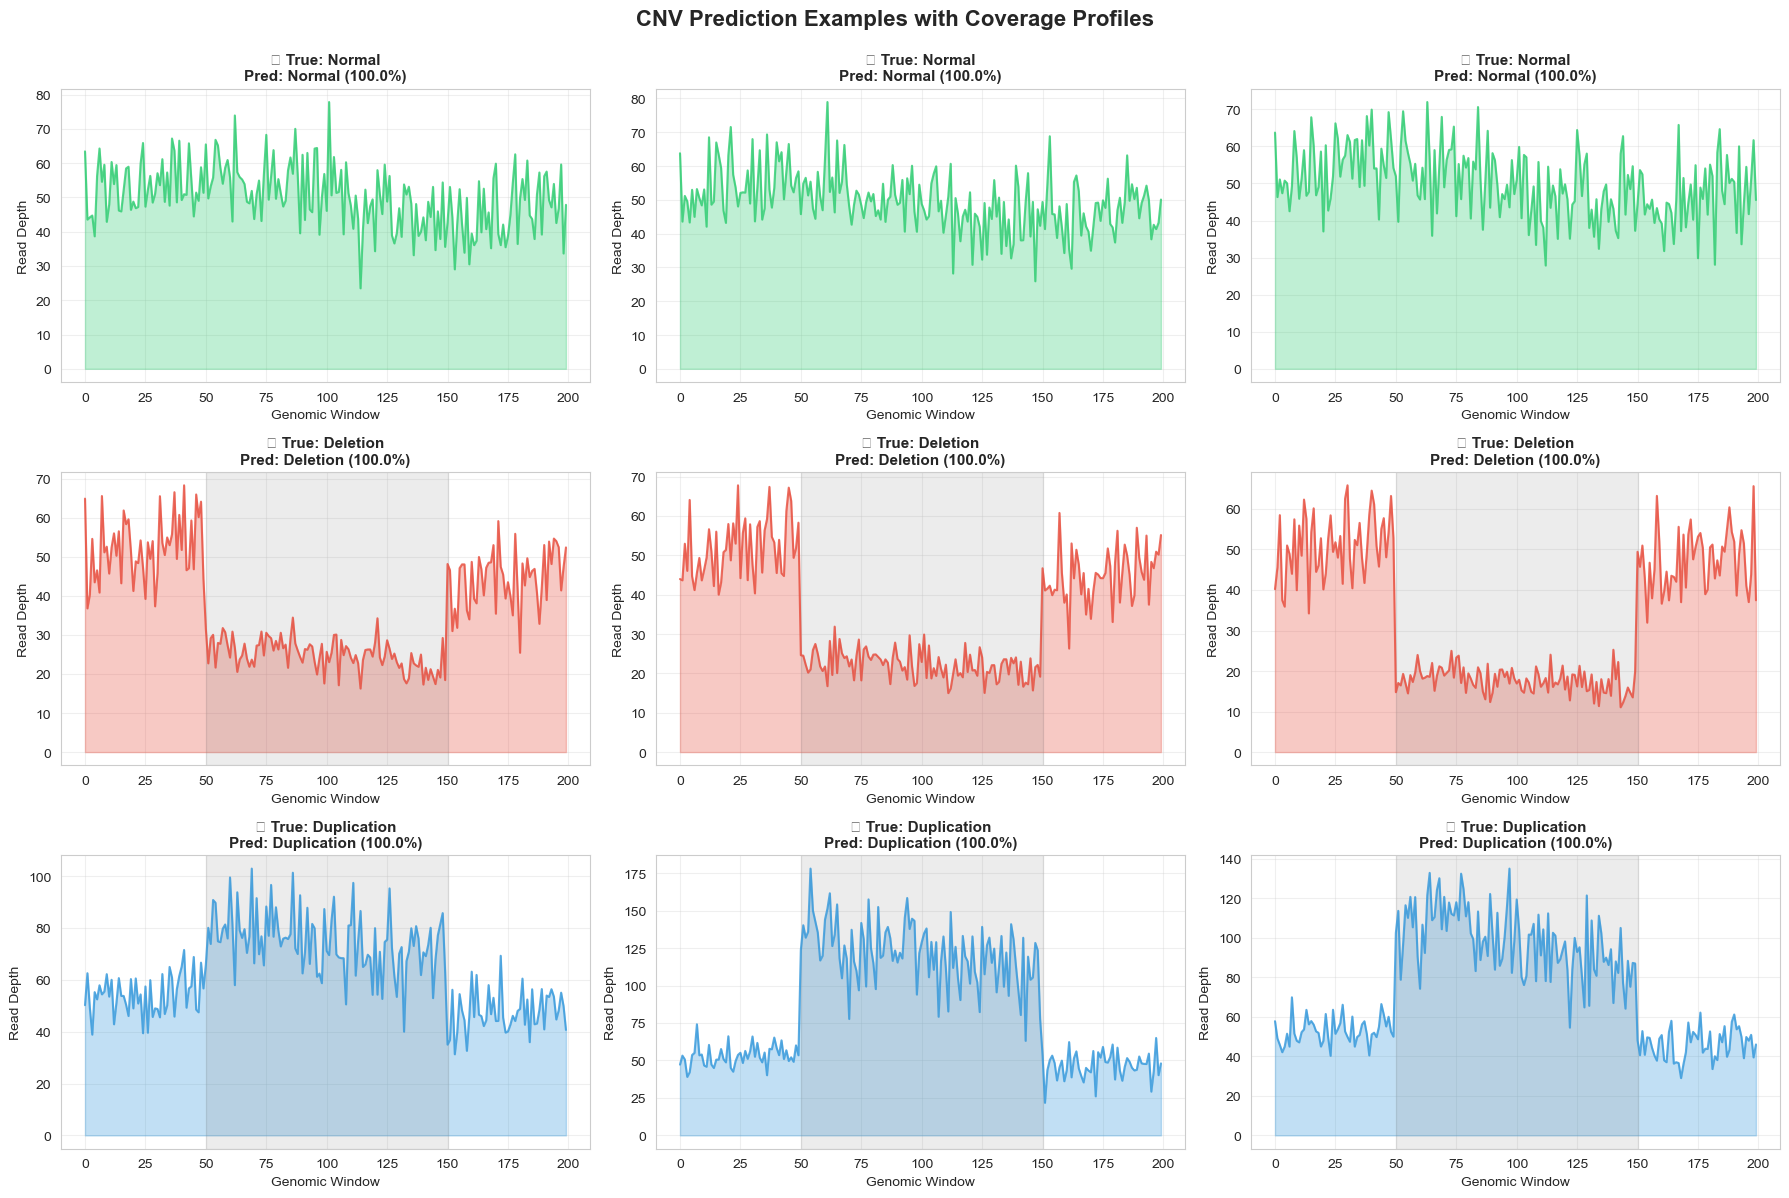

✓ Prediction examples saved to: outputs/prediction_examples.png


In [15]:
# Prediction examples with coverage profiles
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for class_idx in range(3):
    # Find examples of each class
    class_indices = np.where(y_test == class_idx)[0][:3]
    
    for i, idx in enumerate(class_indices):
        ax = axes[class_idx, i]
        coverage = X_test[idx].flatten()
        
        # Get prediction
        pred_class = all_preds[idx]
        pred_prob = all_probs[idx, pred_class] * 100
        
        # Plot coverage
        color = colors[class_idx]
        ax.plot(coverage, color=color, linewidth=1.5, alpha=0.8)
        ax.fill_between(range(len(coverage)), coverage, alpha=0.3, color=color)
        
        # Title with prediction
        correct = "✓" if pred_class == class_idx else "✗"
        title = f"{correct} True: {class_names[class_idx]}\nPred: {class_names[pred_class]} ({pred_prob:.1f}%)"
        ax.set_title(title, fontsize=11, fontweight='bold')
        
        ax.set_xlabel('Genomic Window', fontsize=10)
        ax.set_ylabel('Read Depth', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Highlight CNV region for deletions and duplications
        if class_idx > 0:
            ax.axvspan(50, 150, alpha=0.15, color='gray')

plt.suptitle('CNV Prediction Examples with Coverage Profiles', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'prediction_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Prediction examples saved to: {OUTPUT_DIR / 'prediction_examples.png'}")

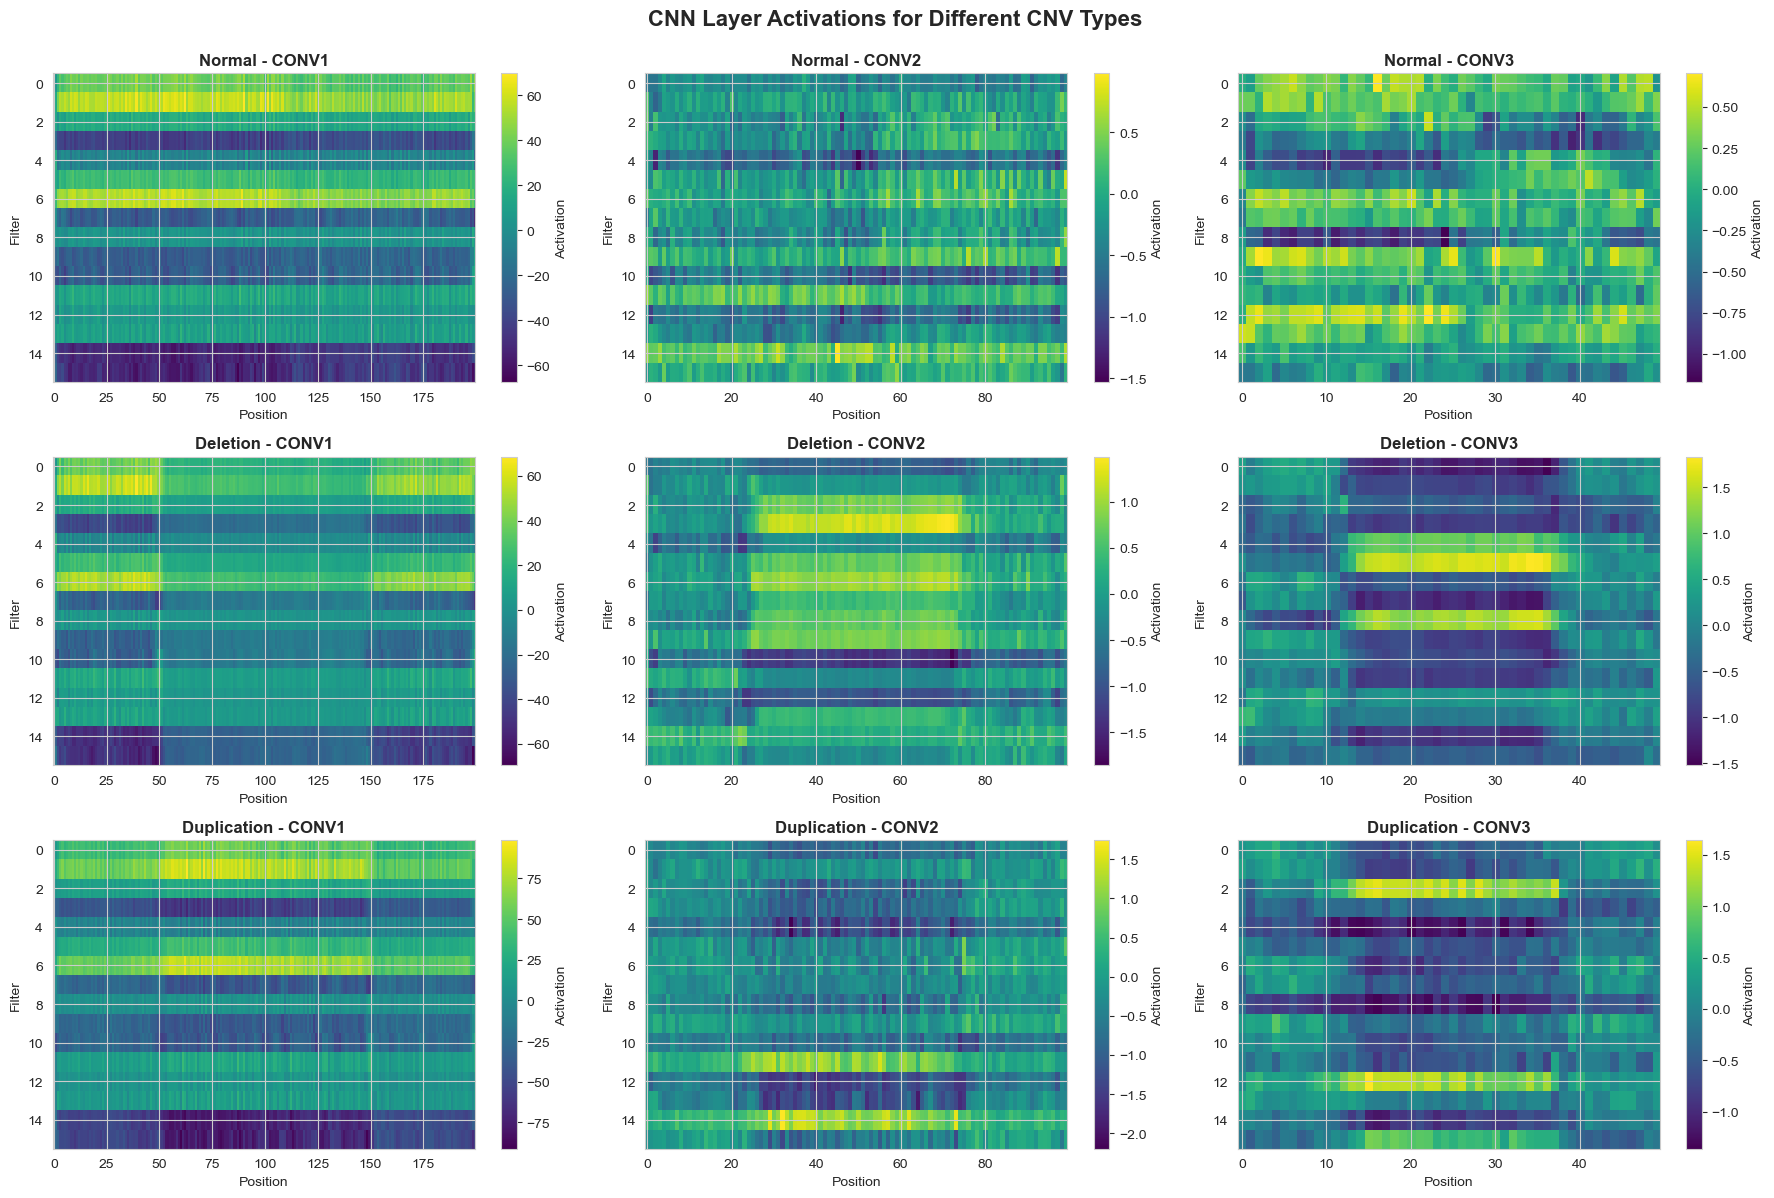

✓ Layer activations saved to: outputs/layer_activations.png


In [16]:
# Feature importance via layer activations
def get_conv_activations(model, x, layer_name='conv1'):
    """
    Extract activations from a specific convolutional layer.
    """
    activations = {}
    
    def hook_fn(module, input, output):
        activations['output'] = output.detach()
    
    # Register hook
    if layer_name == 'conv1':
        hook = model.conv1.register_forward_hook(hook_fn)
    elif layer_name == 'conv2':
        hook = model.conv2.register_forward_hook(hook_fn)
    elif layer_name == 'conv3':
        hook = model.conv3.register_forward_hook(hook_fn)
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(x)
    
    hook.remove()
    return activations['output']

# Visualize activations for one example of each class
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

layer_names = ['conv1', 'conv2', 'conv3']

for class_idx in range(3):
    # Get one example
    example_idx = np.where(y_test == class_idx)[0][0]
    example = torch.from_numpy(X_test[example_idx:example_idx+1]).to(device)
    
    for layer_idx, layer_name in enumerate(layer_names):
        ax = axes[class_idx, layer_idx]
        
        # Get activations
        activations = get_conv_activations(model, example, layer_name)
        act_np = activations.cpu().numpy()[0]  # Shape: (channels, length)
        
        # Plot heatmap of activations
        im = ax.imshow(act_np[:16], aspect='auto', cmap='viridis', interpolation='nearest')
        ax.set_title(f'{class_names[class_idx]} - {layer_name.upper()}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Position', fontsize=10)
        ax.set_ylabel('Filter', fontsize=10)
        plt.colorbar(im, ax=ax, label='Activation')

plt.suptitle('CNN Layer Activations for Different CNV Types', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'layer_activations.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Layer activations saved to: {OUTPUT_DIR / 'layer_activations.png'}")

## 5. Summary Statistics

In [17]:
# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds)

# Create summary table
summary_data = {
    'Class': class_names,
    'Precision': [f"{p:.4f}" for p in precision],
    'Recall': [f"{r:.4f}" for r in recall],
    'F1-Score': [f"{f:.4f}" for f in f1],
    'Support': support.astype(int)
}

# Overall accuracy
accuracy = np.mean(all_preds == all_labels) * 100

print("\n" + "="*70)
print("CNV DETECTION MODEL - FINAL PERFORMANCE SUMMARY")
print("="*70)
print(f"\nOverall Accuracy: {accuracy:.2f}%\n")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*70)
for i in range(len(class_names)):
    print(f"{summary_data['Class'][i]:<15} {summary_data['Precision'][i]:<12} "
          f"{summary_data['Recall'][i]:<12} {summary_data['F1-Score'][i]:<12} "
          f"{summary_data['Support'][i]:<10}")
print("="*70)

# Additional metrics
print(f"\nModel Parameters: {total_params:,}")
print(f"Training Epochs: {num_epochs}")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {accuracy:.2f}%")

print("\n" + "="*70)
print(f"All visualizations have been saved to: {OUTPUT_DIR.absolute()}")
print("="*70)


CNV DETECTION MODEL - FINAL PERFORMANCE SUMMARY

Overall Accuracy: 100.00%

Class           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
Normal          1.0000       1.0000       1.0000       200       
Deletion        1.0000       1.0000       1.0000       200       
Duplication     1.0000       1.0000       1.0000       200       

Model Parameters: 888,451
Training Epochs: 50
Best Validation Accuracy: 100.00%
Final Test Accuracy: 100.00%

All visualizations have been saved to: /Users/shanebrubaker/work/courses/outputs


## Clinical Interpretation Guidelines

### Model Output Interpretation:

1. **Normal (Class 0)**: Diploid copy number (2 copies)
   - Expected in regions without structural variants
   - Confidence >95% recommended for clinical reporting

2. **Deletion (Class 1)**: Copy number loss
   - Hemizygous deletion (1 copy) or homozygous deletion (0 copies)
   - May indicate pathogenic variants if in disease-associated regions
   - Recommend orthogonal validation (e.g., MLPA, qPCR)

3. **Duplication (Class 2)**: Copy number gain
   - Heterozygous duplication (3 copies) or higher amplification
   - Clinical significance depends on gene dosage sensitivity
   - Consider breakpoint mapping for precise characterization

### Quality Control Recommendations:
- Minimum coverage: 30x for reliable CNV calling
- GC content normalization applied during preprocessing
- Manual review recommended for predictions with <90% confidence
- Consider batch effects in multi-sample analyses

### Limitations:
- Model trained on simulated data; validation on real clinical samples required
- Resolution limited to window size (200 bins in this implementation)
- Complex rearrangements may require additional analysis
- Balanced sex chromosomes and common variants not specifically modeled

In [ ]:
## End of Notebook ##